In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from scipy import stats

In [2]:
df=pd.read_csv('ProjectData.csv')

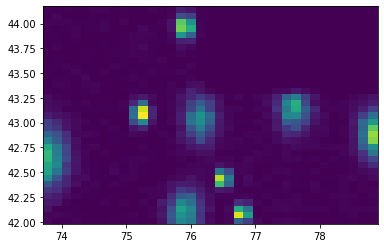

In [3]:
prob = plt.hist2d(df['Lon'],df['Lat'],bins=35,density=True)[0];
x_bins = plt.hist2d(df['Lon'],df['Lat'],bins=35,density=True)[1];
y_bins = plt.hist2d(df['Lon'],df['Lat'],bins=35,density=True)[2];
x_bin_width = (x_bins[1] - x_bins[0])
y_bin_width = (y_bins[1] - y_bins[0])
bin_area = x_bin_width * y_bin_width
prob *= bin_area

marginal_prob_x_axis = np.cumsum(np.sum(prob, axis=1))
marginal_prob_y_axis = [np.cumsum(prob[i,:] / np.sum(prob[i,:])) for i in range(len(x_bins)-1)]
                                 
def generate_location():
    x_bin_coord_ind = np.sum(np.random.uniform() > marginal_prob_x_axis)
    x_coord = x_bins[x_bin_coord_ind]
    
    y_bin_coord_ind = np.sum(np.random.uniform() > marginal_prob_y_axis[x_bin_coord_ind])
    y_coord = y_bins[y_bin_coord_ind]

    x_coord += np.random.uniform() * x_bin_width
    y_coord += np.random.uniform() * y_bin_width

    return [x_coord, y_coord]

In [4]:
def initialize_event_list():
    time = df['Time']
    days = np.ceil(time/24)
    counts = np.zeros(24)
    for i in range(df.shape[0]):
        interval = int(time[i]) % 24
        counts[interval] += 1

    lambda_rates = counts/(max(days))

    event_list = []

    lambda_max = np.max(lambda_rates)
    t = 0
    i = 0

    while t <= 24 * 14:
        t += np.random.exponential(1/lambda_max)
        if np.random.uniform() * lambda_max <= lambda_rates[int(np.floor(t%24))]:
            location = generate_location()
            event_list.append([t,'call', i, location])
            i += 1
    
    return event_list

In [5]:
#Hospital and major trauma center (MTC) locations
hosp_locs = [ [76.5019, 42.4440], [76.8077, 42.0898], [76.5155, 41.9790], [75.2327, 43.1009], 
            [75.9108, 43.9748], [75.9180, 42.0987], [78.8784, 42.8864], [77.6088, 43.1566], 
            [73.7562, 42.6526], [76.1474, 43.0481] ]

mtc_indices = [2,7,8,9]
mtc_locs = [hosp_locs[i] for i in mtc_indices]

In [6]:
def making_decision_HD(t, call_ind):
    return [t + np.random.triangular(5/60,7/60,10/60), 'HD decision', call_ind]

In [7]:
from haversine import haversine

def heli_avaliable(call_location, heli_states):
    dists = [haversine((-call_location[0], call_location[1]), (-heli_locs[i][0], heli_locs[i][1])) 
             if heli_states[i] == 1 else np.inf for i in range(n)]
    if np.min(dists) > range_heli:
        return -1
    else:
        return np.argmin(dists)

In [8]:
def made_decision_HD(event, heli_states): #HD event
    call_ind = event[2]
    call_location = call_ref[call_ind][3]
    
    if np.random.uniform() < p_not_safe:
            return 'unsafe'
        
    best_heli = heli_avaliable(call_location, heli_states)
    if best_heli == -1 or heli_states[best_heli] == 0:
        return 'unavaliable'
    
    heli_states[best_heli] = 0
    best_heli_loc = heli_locs[best_heli]
    takeoff_time = np.random.triangular(5/60,7.5/60,10/60)
    travel_time = haversine((-call_location[0], call_location[1]), (-best_heli_loc[0], best_heli_loc[1])) / heli_speed
    total_time = takeoff_time + travel_time
    
    CT = np.random.exponential(1/0.205) #0.205 rate for cancellation time
    if CT < 0.5 or CT < total_time: #condition
        return [t + CT*2, 'Arrived at Base', best_heli]
    else:
        return [t + total_time, 'Arrived at Scene', call_ind, best_heli]

In [9]:
def making_decision_at_site(t, event, call_ind, heli_ind):
    return [t + np.random.gamma(2.95,0.12), 'Decision made at Scene', call_ind, heli_ind]

In [10]:
def made_decision_at_site(t, event, call_ind, heli_ind):
    
    call_location = call_ref[call_ind][3]
    hosp_dists = [haversine((-call_location[0], call_location[1]), (-hosp_loc[0], hosp_loc[1])) for hosp_loc in hosp_locs]
    best_hosp = np.argmin(hosp_dists)
    best_hosp_loc = hosp_locs[best_hosp]
    
    if best_hosp in mtc_indices:
        travel_time = haversine((-call_location[0], call_location[1]), (-best_hosp_loc[0], best_hosp_loc[1])) / heli_speed
        return [t + travel_time, 'Arrived at Hospital', best_hosp, heli_ind]
    
    elif np.random.uniform() < 1-h: #require special treatment
        mtc_dists = [haversine((-call_location[0], call_location[1]), (-mtc_loc[0], mtc_loc[1])) for mtc_loc in mtc_locs]
        best_mtc = mtc_indices[np.argmin(mtc_dists)]
        best_mtc_loc = hosp_locs[best_mtc]
        travel_time = haversine((-call_location[0], call_location[1]), (-best_mtc_loc[0], best_mtc_loc[1])) / heli_speed
        return [t + travel_time, 'Arrived at Hospital', best_mtc, heli_ind]
    
    else:
        travel_time = haversine((-call_location[0], call_location[1]), (-best_hosp_loc[0], best_hosp_loc[1])) / heli_speed
        return [t + travel_time, 'Arrived at Hospital', best_hosp, heli_ind]

In [11]:
def making_decision_at_hosp(t, event, hosp_ind, heli_ind):
    hosp_loc = hosp_locs[hosp_ind]
    heli_loc = heli_locs[heli_ind]
    unloading_time = np.random.gamma(2.91,0.17)
    
    if hosp_loc == heli_loc:
        total_time = unloading_time
        return [t + total_time, 'Arrived at Base', heli_ind]
    else: 
        travel_time = haversine((-hosp_loc[0], hosp_loc[1]), (-heli_loc[0], heli_loc[1])) / heli_speed
        total_time = unloading_time + travel_time
        return [t + total_time, 'Arrived at Base', heli_ind]

In [12]:
print('Number of hospitals (including MTCs):\t', len(hosp_locs))

Number of hospitals (including MTCs):	 10


In [13]:
print('MTC indices:\t', mtc_indices)

MTC indices:	 [2, 7, 8, 9]


In [17]:
#Initialization
#Initialize locations of helicopters -- this is the control
#n = 12 #Number of helicopters
#heli_ind_locs = [0,1,2,2,2,3,4,5,6,6,6,7]
n = 1
heli_ind_locs = [0]
assert len(heli_ind_locs) == n
heli_locs = [hosp_locs[i] for i in heli_ind_locs]
heli_states = [1] * n

#Initialize the event list with calls and make a copy for reference
event_list = initialize_event_list()
call_ref = event_list.copy()

#Hyperparameters given/estimated from dataset
heli_speed = 160
p_not_safe = 0.101 # Assumed to be 0.101 w/ 95% conﬁdence interval of [0.096,0.106]
h = 0.807 #Percent of call whose closest hospital != MTC, yet still go to closest hospital (as opposed to requiring an MTC)
range_heli = 180 #Range of helicopter's reach

# Performance metrics
unsafe_calls = 0 
unavaliable_calls = 0

#Main iteration
import bisect 
t = 0

while True:
    if (t > 24 *14) or (len(event_list) == 0):
        break

    event = event_list.pop(0)
    t = event[0]
    event_type = event[1]

    #print(event)

    if event_type == 'call':
        gen_event = making_decision_HD(t, event[2])
        bisect.insort(event_list, gen_event)

    if event_type == 'HD decision': 
        gen_event = made_decision_HD(event, heli_states)
        if gen_event == 'unsafe':
            unsafe_calls += 1
        elif gen_event == 'unavaliable':
            unavaliable_calls += 1
        else:
            bisect.insort(event_list, gen_event)

    if event_type == 'Arrived at Scene':
        gen_event = making_decision_at_site(t, event, event[2], event[3]) #call id & associated helicopter id: redundant? yes
        bisect.insort(event_list, gen_event)

    if event_type == 'Decision made at Scene':
        gen_event = made_decision_at_site(t, event, event[2], event[3])
        bisect.insort(event_list, gen_event)

    if event_type == 'Arrived at Hospital':
        gen_event = making_decision_at_hosp(t, event, event[2], event[3])
        bisect.insort(event_list, gen_event)

    if event_type == 'Arrived at Base':
        heli_states[event[2]] = 1

print('Number of calls in 2 week period: \t', len(call_ref))
print('Number of calls that were deemed unsafe:\t', unsafe_calls)
print('Number of calls that could not be answered (but were safe):\t', unavaliable_calls)
print('Percentage_dispatched:\t', (len(call_ref)-unavaliable_calls)/len(call_ref))

Number of calls in 2 week period: 	 685
Number of calls that were deemed unsafe:	 63
Number of calls that could not be answered (but were safe):	 521
Percentage_dispatched:	 0.23941605839416058


In [29]:
def simulate(number, loc):
    #n = number
    heli_ind_locs = loc
    assert len(heli_ind_locs) == number
    heli_locs = [hosp_locs[i] for i in heli_ind_locs]
    heli_states = [1] * number

    #Initialize the event list with calls and make a copy for reference
    event_list = initialize_event_list()
    call_ref = event_list.copy()

    #Hyperparameters given/estimated from dataset
    heli_speed = 160
    p_not_safe = 0.101 # Assumed to be 0.101 w/ 95% conﬁdence interval of [0.096,0.106]
    h = 0.807 #Percent of call whose closest hospital != MTC, yet still go to closest hospital (as opposed to requiring an MTC)
    range_heli = 180 #Range of helicopter's reach

    # Performance metrics
    unsafe_calls = 0 
    unavaliable_calls = 0

    #Main iteration
    import bisect 
    t = 0

    while True:
        if (t > 24 *14) or (len(event_list) == 0):
            break

        event = event_list.pop(0)
        t = event[0]
        event_type = event[1]

        if event_type == 'call':
            gen_event = making_decision_HD(t, event[2])
            bisect.insort(event_list, gen_event)

        if event_type == 'HD decision': 
            gen_event = made_decision_HD(event, heli_states)
            if gen_event == 'unsafe':
                unsafe_calls += 1
            elif gen_event == 'unavaliable':
                unavaliable_calls += 1
            else:
                bisect.insort(event_list, gen_event)

        if event_type == 'Arrived at Scene':
            gen_event = making_decision_at_site(t, event, event[2], event[3]) #call id & associated helicopter id: redundant? yes
            bisect.insort(event_list, gen_event)

        if event_type == 'Decision made at Scene':
            gen_event = made_decision_at_site(t, event, event[2], event[3])
            bisect.insort(event_list, gen_event)

        if event_type == 'Arrived at Hospital':
            gen_event = making_decision_at_hosp(t, event, event[2], event[3])
            bisect.insort(event_list, gen_event)

        if event_type == 'Arrived at Base':
            heli_states[event[2]] = 1

    #print('Number of calls in 2 week period: \t', len(call_ref))
    #print('Number of calls that were deemed unsafe:\t', unsafe_calls)
    #print('Number of calls that could not be answered (but were safe):\t', unavaliable_calls)
    print('Percentage_dispatched:\t', (len(call_ref)-unavaliable_calls)/len(call_ref))
    percentage_dispatched = (len(call_ref)-unavaliable_calls)/len(call_ref)
    models.append(percentage_dispatched)
                

In [109]:
simulate(10, [1,2,3,4,5,6,7,8,9,0])

Percentage_dispatched:	 0.1092814371257485


In [100]:
from itertools import combinations_with_replacement

def test(n):
    items = [0,1,2,3,4,5,6,7,8,9]
    locs = []
    for c in combinations_with_replacement(items, n): # one city may have multiple helicopters
        locs.append(c)
        #print(c)
    for l in locs:
        simulate(n, l)
    max_value = max(models)
    max_index = models.index(max_value)
    print('The optimal solution for ' +str(n)+ ' helicopters position is '+ str(locs[max_index]))

In [108]:
models = [] # need test for multiple times? 
test(1)  # Bug still exist when test high order

Percentage_dispatched:	 0.1111111111111111
Percentage_dispatched:	 0.1060126582278481
Percentage_dispatched:	 0.10267857142857142
Percentage_dispatched:	 0.12101910828025478
Percentage_dispatched:	 0.09442724458204334
Percentage_dispatched:	 0.09900990099009901
Percentage_dispatched:	 0.11060606060606061
Percentage_dispatched:	 0.10047846889952153
Percentage_dispatched:	 0.09724473257698542
Percentage_dispatched:	 0.09146341463414634
The optimal solution for 1 helicopters position is (3,)


In [32]:
items = [0,1,2,3,4,5,6,7,8,9]
locs = []
for c in combinations_with_replacement(items, 12):
    print(c)

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 6)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 8)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 7)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 8)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 9)
(

(0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 5, 8)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 5, 9)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 6, 6)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 6, 7)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 6, 8)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 6, 9)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 7, 7)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 7, 8)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 7, 9)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 8, 8)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 8, 9)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 9, 9)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 5, 5)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 5, 6)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 5, 7)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 5, 8)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 5, 9)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 6, 6)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 6, 7)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 6, 8)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 6, 9)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 7, 7)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 7, 8)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 7, 9)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 8, 8)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 8, 9)
(0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 9, 9)
(

(0, 0, 0, 0, 0, 0, 3, 3, 5, 6, 7, 7)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 6, 7, 8)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 6, 7, 9)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 6, 8, 8)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 6, 8, 9)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 6, 9, 9)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 7, 7, 7)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 7, 7, 8)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 7, 7, 9)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 7, 8, 8)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 7, 8, 9)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 7, 9, 9)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 8, 8, 8)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 8, 8, 9)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 8, 9, 9)
(0, 0, 0, 0, 0, 0, 3, 3, 5, 9, 9, 9)
(0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 6, 6)
(0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 6, 7)
(0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 6, 8)
(0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 6, 9)
(0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 7)
(0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 8)
(0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 7, 9)
(0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 8, 8)
(0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 8, 9)
(0, 0, 0, 0, 0, 0, 3, 3, 6, 6, 9, 9)
(0, 0, 0, 0, 0, 0, 3, 3, 6, 7, 7, 7)
(

(0, 0, 0, 0, 0, 1, 1, 6, 6, 6, 6, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 6, 7, 7)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 6, 7, 8)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 6, 7, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 6, 8, 8)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 6, 8, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 6, 9, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 7, 7, 7)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 7, 7, 8)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 7, 7, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 7, 8, 8)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 7, 8, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 7, 9, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 8, 8, 8)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 8, 8, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 8, 9, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 6, 9, 9, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 7, 7, 7, 7)
(0, 0, 0, 0, 0, 1, 1, 6, 7, 7, 7, 8)
(0, 0, 0, 0, 0, 1, 1, 6, 7, 7, 7, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 7, 7, 8, 8)
(0, 0, 0, 0, 0, 1, 1, 6, 7, 7, 8, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 7, 7, 9, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 7, 8, 8, 8)
(0, 0, 0, 0, 0, 1, 1, 6, 7, 8, 8, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 7, 8, 9, 9)
(0, 0, 0, 0, 0, 1, 1, 6, 7, 9, 9, 9)
(

(0, 0, 0, 0, 0, 2, 2, 2, 4, 5, 6, 7)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 5, 6, 8)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 5, 6, 9)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 5, 7, 7)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 5, 7, 8)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 5, 7, 9)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 5, 8, 8)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 5, 8, 9)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 5, 9, 9)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 6, 6, 6)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 6, 6, 7)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 6, 6, 8)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 6, 6, 9)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 6, 7, 7)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 6, 7, 8)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 6, 7, 9)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 6, 8, 8)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 6, 8, 9)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 6, 9, 9)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 7, 7, 7)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 7, 7, 8)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 7, 7, 9)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 7, 8, 8)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 7, 8, 9)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 7, 9, 9)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 8, 8, 8)
(0, 0, 0, 0, 0, 2, 2, 2, 4, 8, 8, 9)
(

(0, 0, 0, 0, 0, 3, 4, 4, 4, 8, 8, 8)
(0, 0, 0, 0, 0, 3, 4, 4, 4, 8, 8, 9)
(0, 0, 0, 0, 0, 3, 4, 4, 4, 8, 9, 9)
(0, 0, 0, 0, 0, 3, 4, 4, 4, 9, 9, 9)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 5, 5)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 5, 6)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 5, 7)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 5, 8)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 5, 9)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 6, 6)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 6, 7)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 6, 8)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 6, 9)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 7, 7)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 7, 8)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 7, 9)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 8, 8)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 8, 9)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 9, 9)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 6, 6)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 6, 7)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 6, 8)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 6, 9)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 7, 7)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 7, 8)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 7, 9)
(0, 0, 0, 0, 0, 3, 4, 4, 5, 6, 8, 8)
(

(0, 0, 0, 0, 1, 1, 1, 2, 6, 6, 8, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 6, 6, 9, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 6, 7, 7, 7)
(0, 0, 0, 0, 1, 1, 1, 2, 6, 7, 7, 8)
(0, 0, 0, 0, 1, 1, 1, 2, 6, 7, 7, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 6, 7, 8, 8)
(0, 0, 0, 0, 1, 1, 1, 2, 6, 7, 8, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 6, 7, 9, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 6, 8, 8, 8)
(0, 0, 0, 0, 1, 1, 1, 2, 6, 8, 8, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 6, 8, 9, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 6, 9, 9, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 7, 7, 7, 7)
(0, 0, 0, 0, 1, 1, 1, 2, 7, 7, 7, 8)
(0, 0, 0, 0, 1, 1, 1, 2, 7, 7, 7, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 7, 7, 8, 8)
(0, 0, 0, 0, 1, 1, 1, 2, 7, 7, 8, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 7, 7, 9, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 7, 8, 8, 8)
(0, 0, 0, 0, 1, 1, 1, 2, 7, 8, 8, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 7, 8, 9, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 7, 9, 9, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 8, 8, 8, 8)
(0, 0, 0, 0, 1, 1, 1, 2, 8, 8, 8, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 8, 8, 9, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 8, 9, 9, 9)
(0, 0, 0, 0, 1, 1, 1, 2, 9, 9, 9, 9)
(

(0, 0, 0, 0, 1, 1, 5, 5, 5, 5, 5, 9)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 5, 6, 6)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 5, 6, 7)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 5, 6, 8)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 5, 6, 9)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 5, 7, 7)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 5, 7, 8)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 5, 7, 9)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 5, 8, 8)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 5, 8, 9)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 5, 9, 9)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 6, 6, 6)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 6, 6, 7)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 6, 6, 8)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 6, 6, 9)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 6, 7, 7)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 6, 7, 8)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 6, 7, 9)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 6, 8, 8)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 6, 8, 9)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 6, 9, 9)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 7, 7, 7)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 7, 7, 8)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 7, 7, 9)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 7, 8, 8)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 7, 8, 9)
(0, 0, 0, 0, 1, 1, 5, 5, 5, 7, 9, 9)
(

(0, 0, 0, 0, 1, 3, 3, 3, 3, 7, 8, 9)
(0, 0, 0, 0, 1, 3, 3, 3, 3, 7, 9, 9)
(0, 0, 0, 0, 1, 3, 3, 3, 3, 8, 8, 8)
(0, 0, 0, 0, 1, 3, 3, 3, 3, 8, 8, 9)
(0, 0, 0, 0, 1, 3, 3, 3, 3, 8, 9, 9)
(0, 0, 0, 0, 1, 3, 3, 3, 3, 9, 9, 9)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 4, 4)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 4, 5)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 4, 6)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 4, 7)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 4, 8)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 4, 9)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 5, 5)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 5, 6)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 5, 7)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 5, 8)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 5, 9)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 6, 6)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 6, 7)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 6, 8)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 6, 9)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 7, 7)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 7, 8)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 7, 9)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 8, 8)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 8, 9)
(0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 9, 9)
(

(0, 0, 0, 0, 1, 5, 7, 7, 7, 9, 9, 9)
(0, 0, 0, 0, 1, 5, 7, 7, 8, 8, 8, 8)
(0, 0, 0, 0, 1, 5, 7, 7, 8, 8, 8, 9)
(0, 0, 0, 0, 1, 5, 7, 7, 8, 8, 9, 9)
(0, 0, 0, 0, 1, 5, 7, 7, 8, 9, 9, 9)
(0, 0, 0, 0, 1, 5, 7, 7, 9, 9, 9, 9)
(0, 0, 0, 0, 1, 5, 7, 8, 8, 8, 8, 8)
(0, 0, 0, 0, 1, 5, 7, 8, 8, 8, 8, 9)
(0, 0, 0, 0, 1, 5, 7, 8, 8, 8, 9, 9)
(0, 0, 0, 0, 1, 5, 7, 8, 8, 9, 9, 9)
(0, 0, 0, 0, 1, 5, 7, 8, 9, 9, 9, 9)
(0, 0, 0, 0, 1, 5, 7, 9, 9, 9, 9, 9)
(0, 0, 0, 0, 1, 5, 8, 8, 8, 8, 8, 8)
(0, 0, 0, 0, 1, 5, 8, 8, 8, 8, 8, 9)
(0, 0, 0, 0, 1, 5, 8, 8, 8, 8, 9, 9)
(0, 0, 0, 0, 1, 5, 8, 8, 8, 9, 9, 9)
(0, 0, 0, 0, 1, 5, 8, 8, 9, 9, 9, 9)
(0, 0, 0, 0, 1, 5, 8, 9, 9, 9, 9, 9)
(0, 0, 0, 0, 1, 5, 9, 9, 9, 9, 9, 9)
(0, 0, 0, 0, 1, 6, 6, 6, 6, 6, 6, 6)
(0, 0, 0, 0, 1, 6, 6, 6, 6, 6, 6, 7)
(0, 0, 0, 0, 1, 6, 6, 6, 6, 6, 6, 8)
(0, 0, 0, 0, 1, 6, 6, 6, 6, 6, 6, 9)
(0, 0, 0, 0, 1, 6, 6, 6, 6, 6, 7, 7)
(0, 0, 0, 0, 1, 6, 6, 6, 6, 6, 7, 8)
(0, 0, 0, 0, 1, 6, 6, 6, 6, 6, 7, 9)
(0, 0, 0, 0, 1, 6, 6, 6, 6, 6, 8, 8)
(

(0, 0, 0, 0, 2, 3, 3, 3, 5, 5, 6, 6)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 5, 6, 7)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 5, 6, 8)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 5, 6, 9)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 5, 7, 7)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 5, 7, 8)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 5, 7, 9)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 5, 8, 8)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 5, 8, 9)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 5, 9, 9)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 6, 6, 6)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 6, 6, 7)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 6, 6, 8)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 6, 6, 9)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 6, 7, 7)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 6, 7, 8)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 6, 7, 9)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 6, 8, 8)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 6, 8, 9)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 6, 9, 9)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 7, 7, 7)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 7, 7, 8)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 7, 7, 9)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 7, 8, 8)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 7, 8, 9)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 7, 9, 9)
(0, 0, 0, 0, 2, 3, 3, 3, 5, 8, 8, 8)
(

(0, 0, 0, 0, 3, 3, 3, 6, 7, 7, 7, 9)
(0, 0, 0, 0, 3, 3, 3, 6, 7, 7, 8, 8)
(0, 0, 0, 0, 3, 3, 3, 6, 7, 7, 8, 9)
(0, 0, 0, 0, 3, 3, 3, 6, 7, 7, 9, 9)
(0, 0, 0, 0, 3, 3, 3, 6, 7, 8, 8, 8)
(0, 0, 0, 0, 3, 3, 3, 6, 7, 8, 8, 9)
(0, 0, 0, 0, 3, 3, 3, 6, 7, 8, 9, 9)
(0, 0, 0, 0, 3, 3, 3, 6, 7, 9, 9, 9)
(0, 0, 0, 0, 3, 3, 3, 6, 8, 8, 8, 8)
(0, 0, 0, 0, 3, 3, 3, 6, 8, 8, 8, 9)
(0, 0, 0, 0, 3, 3, 3, 6, 8, 8, 9, 9)
(0, 0, 0, 0, 3, 3, 3, 6, 8, 9, 9, 9)
(0, 0, 0, 0, 3, 3, 3, 6, 9, 9, 9, 9)
(0, 0, 0, 0, 3, 3, 3, 7, 7, 7, 7, 7)
(0, 0, 0, 0, 3, 3, 3, 7, 7, 7, 7, 8)
(0, 0, 0, 0, 3, 3, 3, 7, 7, 7, 7, 9)
(0, 0, 0, 0, 3, 3, 3, 7, 7, 7, 8, 8)
(0, 0, 0, 0, 3, 3, 3, 7, 7, 7, 8, 9)
(0, 0, 0, 0, 3, 3, 3, 7, 7, 7, 9, 9)
(0, 0, 0, 0, 3, 3, 3, 7, 7, 8, 8, 8)
(0, 0, 0, 0, 3, 3, 3, 7, 7, 8, 8, 9)
(0, 0, 0, 0, 3, 3, 3, 7, 7, 8, 9, 9)
(0, 0, 0, 0, 3, 3, 3, 7, 7, 9, 9, 9)
(0, 0, 0, 0, 3, 3, 3, 7, 8, 8, 8, 8)
(0, 0, 0, 0, 3, 3, 3, 7, 8, 8, 8, 9)
(0, 0, 0, 0, 3, 3, 3, 7, 8, 8, 9, 9)
(0, 0, 0, 0, 3, 3, 3, 7, 8, 9, 9, 9)
(

(0, 0, 0, 0, 5, 5, 5, 5, 7, 8, 9, 9)
(0, 0, 0, 0, 5, 5, 5, 5, 7, 9, 9, 9)
(0, 0, 0, 0, 5, 5, 5, 5, 8, 8, 8, 8)
(0, 0, 0, 0, 5, 5, 5, 5, 8, 8, 8, 9)
(0, 0, 0, 0, 5, 5, 5, 5, 8, 8, 9, 9)
(0, 0, 0, 0, 5, 5, 5, 5, 8, 9, 9, 9)
(0, 0, 0, 0, 5, 5, 5, 5, 9, 9, 9, 9)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 6, 6)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 6, 7)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 6, 8)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 6, 9)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 7, 7)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 7, 8)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 7, 9)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 8, 8)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 8, 9)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 9, 9)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 7, 7, 7)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 7, 7, 8)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 7, 7, 9)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 7, 8, 8)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 7, 8, 9)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 7, 9, 9)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 8, 8, 8)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 8, 8, 9)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 8, 9, 9)
(0, 0, 0, 0, 5, 5, 5, 6, 6, 9, 9, 9)
(

(0, 0, 0, 1, 1, 1, 2, 2, 6, 6, 7, 7)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 6, 7, 8)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 6, 7, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 6, 8, 8)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 6, 8, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 6, 9, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 7, 7, 7)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 7, 7, 8)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 7, 7, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 7, 8, 8)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 7, 8, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 7, 9, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 8, 8, 8)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 8, 8, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 8, 9, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 6, 9, 9, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 7, 7, 7, 7)
(0, 0, 0, 1, 1, 1, 2, 2, 7, 7, 7, 8)
(0, 0, 0, 1, 1, 1, 2, 2, 7, 7, 7, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 7, 7, 8, 8)
(0, 0, 0, 1, 1, 1, 2, 2, 7, 7, 8, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 7, 7, 9, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 7, 8, 8, 8)
(0, 0, 0, 1, 1, 1, 2, 2, 7, 8, 8, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 7, 8, 9, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 7, 9, 9, 9)
(0, 0, 0, 1, 1, 1, 2, 2, 8, 8, 8, 8)
(

(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 5, 6)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 5, 7)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 5, 8)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 5, 9)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 6, 6)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 6, 7)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 6, 8)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 6, 9)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 7, 7)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 7, 8)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 7, 9)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 8, 8)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 8, 9)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 9, 9)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 5, 5)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 5, 6)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 5, 7)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 5, 8)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 5, 9)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 6)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 7)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 8)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 9)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 7, 7)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 7, 8)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 7, 9)
(0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 8, 8)
(

(0, 0, 0, 1, 1, 3, 4, 7, 8, 8, 8, 9)
(0, 0, 0, 1, 1, 3, 4, 7, 8, 8, 9, 9)
(0, 0, 0, 1, 1, 3, 4, 7, 8, 9, 9, 9)
(0, 0, 0, 1, 1, 3, 4, 7, 9, 9, 9, 9)
(0, 0, 0, 1, 1, 3, 4, 8, 8, 8, 8, 8)
(0, 0, 0, 1, 1, 3, 4, 8, 8, 8, 8, 9)
(0, 0, 0, 1, 1, 3, 4, 8, 8, 8, 9, 9)
(0, 0, 0, 1, 1, 3, 4, 8, 8, 9, 9, 9)
(0, 0, 0, 1, 1, 3, 4, 8, 9, 9, 9, 9)
(0, 0, 0, 1, 1, 3, 4, 9, 9, 9, 9, 9)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 5, 5)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 5, 6)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 5, 7)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 5, 8)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 5, 9)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 6, 6)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 6, 7)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 6, 8)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 6, 9)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 7, 7)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 7, 8)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 7, 9)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 8, 8)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 8, 9)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 5, 9, 9)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 6, 6, 6)
(0, 0, 0, 1, 1, 3, 5, 5, 5, 6, 6, 7)
(

(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 5, 6)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 5, 7)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 5, 8)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 5, 9)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 6, 6)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 6, 7)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 6, 8)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 6, 9)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 7, 7)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 7, 8)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 7, 9)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 8, 8)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 8, 9)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 9, 9)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 6, 6, 6)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 6, 6, 7)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 6, 6, 8)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 6, 6, 9)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 6, 7, 7)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 6, 7, 8)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 6, 7, 9)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 6, 8, 8)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 6, 8, 9)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 6, 9, 9)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 7, 7, 7)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 7, 7, 8)
(0, 0, 0, 1, 2, 2, 3, 4, 5, 7, 7, 9)
(

(0, 0, 0, 1, 2, 5, 6, 7, 9, 9, 9, 9)
(0, 0, 0, 1, 2, 5, 6, 8, 8, 8, 8, 8)
(0, 0, 0, 1, 2, 5, 6, 8, 8, 8, 8, 9)
(0, 0, 0, 1, 2, 5, 6, 8, 8, 8, 9, 9)
(0, 0, 0, 1, 2, 5, 6, 8, 8, 9, 9, 9)
(0, 0, 0, 1, 2, 5, 6, 8, 9, 9, 9, 9)
(0, 0, 0, 1, 2, 5, 6, 9, 9, 9, 9, 9)
(0, 0, 0, 1, 2, 5, 7, 7, 7, 7, 7, 7)
(0, 0, 0, 1, 2, 5, 7, 7, 7, 7, 7, 8)
(0, 0, 0, 1, 2, 5, 7, 7, 7, 7, 7, 9)
(0, 0, 0, 1, 2, 5, 7, 7, 7, 7, 8, 8)
(0, 0, 0, 1, 2, 5, 7, 7, 7, 7, 8, 9)
(0, 0, 0, 1, 2, 5, 7, 7, 7, 7, 9, 9)
(0, 0, 0, 1, 2, 5, 7, 7, 7, 8, 8, 8)
(0, 0, 0, 1, 2, 5, 7, 7, 7, 8, 8, 9)
(0, 0, 0, 1, 2, 5, 7, 7, 7, 8, 9, 9)
(0, 0, 0, 1, 2, 5, 7, 7, 7, 9, 9, 9)
(0, 0, 0, 1, 2, 5, 7, 7, 8, 8, 8, 8)
(0, 0, 0, 1, 2, 5, 7, 7, 8, 8, 8, 9)
(0, 0, 0, 1, 2, 5, 7, 7, 8, 8, 9, 9)
(0, 0, 0, 1, 2, 5, 7, 7, 8, 9, 9, 9)
(0, 0, 0, 1, 2, 5, 7, 7, 9, 9, 9, 9)
(0, 0, 0, 1, 2, 5, 7, 8, 8, 8, 8, 8)
(0, 0, 0, 1, 2, 5, 7, 8, 8, 8, 8, 9)
(0, 0, 0, 1, 2, 5, 7, 8, 8, 8, 9, 9)
(0, 0, 0, 1, 2, 5, 7, 8, 8, 9, 9, 9)
(0, 0, 0, 1, 2, 5, 7, 8, 9, 9, 9, 9)
(

(0, 0, 0, 1, 4, 4, 5, 6, 6, 8, 8, 9)
(0, 0, 0, 1, 4, 4, 5, 6, 6, 8, 9, 9)
(0, 0, 0, 1, 4, 4, 5, 6, 6, 9, 9, 9)
(0, 0, 0, 1, 4, 4, 5, 6, 7, 7, 7, 7)
(0, 0, 0, 1, 4, 4, 5, 6, 7, 7, 7, 8)
(0, 0, 0, 1, 4, 4, 5, 6, 7, 7, 7, 9)
(0, 0, 0, 1, 4, 4, 5, 6, 7, 7, 8, 8)
(0, 0, 0, 1, 4, 4, 5, 6, 7, 7, 8, 9)
(0, 0, 0, 1, 4, 4, 5, 6, 7, 7, 9, 9)
(0, 0, 0, 1, 4, 4, 5, 6, 7, 8, 8, 8)
(0, 0, 0, 1, 4, 4, 5, 6, 7, 8, 8, 9)
(0, 0, 0, 1, 4, 4, 5, 6, 7, 8, 9, 9)
(0, 0, 0, 1, 4, 4, 5, 6, 7, 9, 9, 9)
(0, 0, 0, 1, 4, 4, 5, 6, 8, 8, 8, 8)
(0, 0, 0, 1, 4, 4, 5, 6, 8, 8, 8, 9)
(0, 0, 0, 1, 4, 4, 5, 6, 8, 8, 9, 9)
(0, 0, 0, 1, 4, 4, 5, 6, 8, 9, 9, 9)
(0, 0, 0, 1, 4, 4, 5, 6, 9, 9, 9, 9)
(0, 0, 0, 1, 4, 4, 5, 7, 7, 7, 7, 7)
(0, 0, 0, 1, 4, 4, 5, 7, 7, 7, 7, 8)
(0, 0, 0, 1, 4, 4, 5, 7, 7, 7, 7, 9)
(0, 0, 0, 1, 4, 4, 5, 7, 7, 7, 8, 8)
(0, 0, 0, 1, 4, 4, 5, 7, 7, 7, 8, 9)
(0, 0, 0, 1, 4, 4, 5, 7, 7, 7, 9, 9)
(0, 0, 0, 1, 4, 4, 5, 7, 7, 8, 8, 8)
(0, 0, 0, 1, 4, 4, 5, 7, 7, 8, 8, 9)
(0, 0, 0, 1, 4, 4, 5, 7, 7, 8, 9, 9)
(

(0, 0, 0, 2, 2, 2, 3, 4, 7, 7, 7, 7)
(0, 0, 0, 2, 2, 2, 3, 4, 7, 7, 7, 8)
(0, 0, 0, 2, 2, 2, 3, 4, 7, 7, 7, 9)
(0, 0, 0, 2, 2, 2, 3, 4, 7, 7, 8, 8)
(0, 0, 0, 2, 2, 2, 3, 4, 7, 7, 8, 9)
(0, 0, 0, 2, 2, 2, 3, 4, 7, 7, 9, 9)
(0, 0, 0, 2, 2, 2, 3, 4, 7, 8, 8, 8)
(0, 0, 0, 2, 2, 2, 3, 4, 7, 8, 8, 9)
(0, 0, 0, 2, 2, 2, 3, 4, 7, 8, 9, 9)
(0, 0, 0, 2, 2, 2, 3, 4, 7, 9, 9, 9)
(0, 0, 0, 2, 2, 2, 3, 4, 8, 8, 8, 8)
(0, 0, 0, 2, 2, 2, 3, 4, 8, 8, 8, 9)
(0, 0, 0, 2, 2, 2, 3, 4, 8, 8, 9, 9)
(0, 0, 0, 2, 2, 2, 3, 4, 8, 9, 9, 9)
(0, 0, 0, 2, 2, 2, 3, 4, 9, 9, 9, 9)
(0, 0, 0, 2, 2, 2, 3, 5, 5, 5, 5, 5)
(0, 0, 0, 2, 2, 2, 3, 5, 5, 5, 5, 6)
(0, 0, 0, 2, 2, 2, 3, 5, 5, 5, 5, 7)
(0, 0, 0, 2, 2, 2, 3, 5, 5, 5, 5, 8)
(0, 0, 0, 2, 2, 2, 3, 5, 5, 5, 5, 9)
(0, 0, 0, 2, 2, 2, 3, 5, 5, 5, 6, 6)
(0, 0, 0, 2, 2, 2, 3, 5, 5, 5, 6, 7)
(0, 0, 0, 2, 2, 2, 3, 5, 5, 5, 6, 8)
(0, 0, 0, 2, 2, 2, 3, 5, 5, 5, 6, 9)
(0, 0, 0, 2, 2, 2, 3, 5, 5, 5, 7, 7)
(0, 0, 0, 2, 2, 2, 3, 5, 5, 5, 7, 8)
(0, 0, 0, 2, 2, 2, 3, 5, 5, 5, 7, 9)
(

(0, 0, 0, 2, 2, 5, 6, 7, 8, 8, 9, 9)
(0, 0, 0, 2, 2, 5, 6, 7, 8, 9, 9, 9)
(0, 0, 0, 2, 2, 5, 6, 7, 9, 9, 9, 9)
(0, 0, 0, 2, 2, 5, 6, 8, 8, 8, 8, 8)
(0, 0, 0, 2, 2, 5, 6, 8, 8, 8, 8, 9)
(0, 0, 0, 2, 2, 5, 6, 8, 8, 8, 9, 9)
(0, 0, 0, 2, 2, 5, 6, 8, 8, 9, 9, 9)
(0, 0, 0, 2, 2, 5, 6, 8, 9, 9, 9, 9)
(0, 0, 0, 2, 2, 5, 6, 9, 9, 9, 9, 9)
(0, 0, 0, 2, 2, 5, 7, 7, 7, 7, 7, 7)
(0, 0, 0, 2, 2, 5, 7, 7, 7, 7, 7, 8)
(0, 0, 0, 2, 2, 5, 7, 7, 7, 7, 7, 9)
(0, 0, 0, 2, 2, 5, 7, 7, 7, 7, 8, 8)
(0, 0, 0, 2, 2, 5, 7, 7, 7, 7, 8, 9)
(0, 0, 0, 2, 2, 5, 7, 7, 7, 7, 9, 9)
(0, 0, 0, 2, 2, 5, 7, 7, 7, 8, 8, 8)
(0, 0, 0, 2, 2, 5, 7, 7, 7, 8, 8, 9)
(0, 0, 0, 2, 2, 5, 7, 7, 7, 8, 9, 9)
(0, 0, 0, 2, 2, 5, 7, 7, 7, 9, 9, 9)
(0, 0, 0, 2, 2, 5, 7, 7, 8, 8, 8, 8)
(0, 0, 0, 2, 2, 5, 7, 7, 8, 8, 8, 9)
(0, 0, 0, 2, 2, 5, 7, 7, 8, 8, 9, 9)
(0, 0, 0, 2, 2, 5, 7, 7, 8, 9, 9, 9)
(0, 0, 0, 2, 2, 5, 7, 7, 9, 9, 9, 9)
(0, 0, 0, 2, 2, 5, 7, 8, 8, 8, 8, 8)
(0, 0, 0, 2, 2, 5, 7, 8, 8, 8, 8, 9)
(0, 0, 0, 2, 2, 5, 7, 8, 8, 8, 9, 9)
(

(0, 0, 0, 2, 4, 4, 4, 5, 6, 6, 9, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 6, 7, 7, 7)
(0, 0, 0, 2, 4, 4, 4, 5, 6, 7, 7, 8)
(0, 0, 0, 2, 4, 4, 4, 5, 6, 7, 7, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 6, 7, 8, 8)
(0, 0, 0, 2, 4, 4, 4, 5, 6, 7, 8, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 6, 7, 9, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 6, 8, 8, 8)
(0, 0, 0, 2, 4, 4, 4, 5, 6, 8, 8, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 6, 8, 9, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 6, 9, 9, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 7, 7, 7, 7)
(0, 0, 0, 2, 4, 4, 4, 5, 7, 7, 7, 8)
(0, 0, 0, 2, 4, 4, 4, 5, 7, 7, 7, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 7, 7, 8, 8)
(0, 0, 0, 2, 4, 4, 4, 5, 7, 7, 8, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 7, 7, 9, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 7, 8, 8, 8)
(0, 0, 0, 2, 4, 4, 4, 5, 7, 8, 8, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 7, 8, 9, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 7, 9, 9, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 8, 8, 8, 8)
(0, 0, 0, 2, 4, 4, 4, 5, 8, 8, 8, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 8, 8, 9, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 8, 9, 9, 9)
(0, 0, 0, 2, 4, 4, 4, 5, 9, 9, 9, 9)
(0, 0, 0, 2, 4, 4, 4, 6, 6, 6, 6, 6)
(

(0, 0, 0, 3, 3, 4, 4, 5, 7, 7, 9, 9)
(0, 0, 0, 3, 3, 4, 4, 5, 7, 8, 8, 8)
(0, 0, 0, 3, 3, 4, 4, 5, 7, 8, 8, 9)
(0, 0, 0, 3, 3, 4, 4, 5, 7, 8, 9, 9)
(0, 0, 0, 3, 3, 4, 4, 5, 7, 9, 9, 9)
(0, 0, 0, 3, 3, 4, 4, 5, 8, 8, 8, 8)
(0, 0, 0, 3, 3, 4, 4, 5, 8, 8, 8, 9)
(0, 0, 0, 3, 3, 4, 4, 5, 8, 8, 9, 9)
(0, 0, 0, 3, 3, 4, 4, 5, 8, 9, 9, 9)
(0, 0, 0, 3, 3, 4, 4, 5, 9, 9, 9, 9)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 6, 6, 6)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 6, 6, 7)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 6, 6, 8)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 6, 6, 9)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 6, 7, 7)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 6, 7, 8)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 6, 7, 9)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 6, 8, 8)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 6, 8, 9)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 6, 9, 9)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 7, 7, 7)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 7, 7, 8)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 7, 7, 9)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 7, 8, 8)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 7, 8, 9)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 7, 9, 9)
(0, 0, 0, 3, 3, 4, 4, 6, 6, 8, 8, 8)
(

(0, 0, 0, 4, 4, 4, 4, 4, 7, 7, 7, 7)
(0, 0, 0, 4, 4, 4, 4, 4, 7, 7, 7, 8)
(0, 0, 0, 4, 4, 4, 4, 4, 7, 7, 7, 9)
(0, 0, 0, 4, 4, 4, 4, 4, 7, 7, 8, 8)
(0, 0, 0, 4, 4, 4, 4, 4, 7, 7, 8, 9)
(0, 0, 0, 4, 4, 4, 4, 4, 7, 7, 9, 9)
(0, 0, 0, 4, 4, 4, 4, 4, 7, 8, 8, 8)
(0, 0, 0, 4, 4, 4, 4, 4, 7, 8, 8, 9)
(0, 0, 0, 4, 4, 4, 4, 4, 7, 8, 9, 9)
(0, 0, 0, 4, 4, 4, 4, 4, 7, 9, 9, 9)
(0, 0, 0, 4, 4, 4, 4, 4, 8, 8, 8, 8)
(0, 0, 0, 4, 4, 4, 4, 4, 8, 8, 8, 9)
(0, 0, 0, 4, 4, 4, 4, 4, 8, 8, 9, 9)
(0, 0, 0, 4, 4, 4, 4, 4, 8, 9, 9, 9)
(0, 0, 0, 4, 4, 4, 4, 4, 9, 9, 9, 9)
(0, 0, 0, 4, 4, 4, 4, 5, 5, 5, 5, 5)
(0, 0, 0, 4, 4, 4, 4, 5, 5, 5, 5, 6)
(0, 0, 0, 4, 4, 4, 4, 5, 5, 5, 5, 7)
(0, 0, 0, 4, 4, 4, 4, 5, 5, 5, 5, 8)
(0, 0, 0, 4, 4, 4, 4, 5, 5, 5, 5, 9)
(0, 0, 0, 4, 4, 4, 4, 5, 5, 5, 6, 6)
(0, 0, 0, 4, 4, 4, 4, 5, 5, 5, 6, 7)
(0, 0, 0, 4, 4, 4, 4, 5, 5, 5, 6, 8)
(0, 0, 0, 4, 4, 4, 4, 5, 5, 5, 6, 9)
(0, 0, 0, 4, 4, 4, 4, 5, 5, 5, 7, 7)
(0, 0, 0, 4, 4, 4, 4, 5, 5, 5, 7, 8)
(0, 0, 0, 4, 4, 4, 4, 5, 5, 5, 7, 9)
(

(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 4, 5)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 4, 6)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 4, 7)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 4, 8)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 4, 9)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 5, 5)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 5, 6)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 5, 7)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 5, 8)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 5, 9)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 6, 6)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 6, 7)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 6, 8)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 6, 9)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 7, 7)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 7, 8)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 7, 9)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 8, 8)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 8, 9)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 9, 9)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 5, 5, 6)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 5, 5, 7)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 5, 5, 8)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 5, 5, 9)
(0, 0, 1, 1, 1, 1, 1, 1, 1, 5, 6, 6)
(

(0, 0, 1, 1, 1, 1, 3, 4, 4, 4, 8, 8)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 4, 8, 9)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 4, 9, 9)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 5, 5)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 5, 6)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 5, 7)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 5, 8)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 5, 9)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 6, 6)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 6, 7)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 6, 8)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 6, 9)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 7, 7)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 7, 8)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 7, 9)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 8, 8)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 8, 9)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 5, 9, 9)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 6, 6, 6)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 6, 6, 7)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 6, 6, 8)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 6, 6, 9)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 6, 7, 7)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 6, 7, 8)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 6, 7, 9)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 6, 8, 8)
(0, 0, 1, 1, 1, 1, 3, 4, 4, 6, 8, 9)
(

(0, 0, 1, 1, 1, 2, 3, 6, 8, 8, 8, 9)
(0, 0, 1, 1, 1, 2, 3, 6, 8, 8, 9, 9)
(0, 0, 1, 1, 1, 2, 3, 6, 8, 9, 9, 9)
(0, 0, 1, 1, 1, 2, 3, 6, 9, 9, 9, 9)
(0, 0, 1, 1, 1, 2, 3, 7, 7, 7, 7, 7)
(0, 0, 1, 1, 1, 2, 3, 7, 7, 7, 7, 8)
(0, 0, 1, 1, 1, 2, 3, 7, 7, 7, 7, 9)
(0, 0, 1, 1, 1, 2, 3, 7, 7, 7, 8, 8)
(0, 0, 1, 1, 1, 2, 3, 7, 7, 7, 8, 9)
(0, 0, 1, 1, 1, 2, 3, 7, 7, 7, 9, 9)
(0, 0, 1, 1, 1, 2, 3, 7, 7, 8, 8, 8)
(0, 0, 1, 1, 1, 2, 3, 7, 7, 8, 8, 9)
(0, 0, 1, 1, 1, 2, 3, 7, 7, 8, 9, 9)
(0, 0, 1, 1, 1, 2, 3, 7, 7, 9, 9, 9)
(0, 0, 1, 1, 1, 2, 3, 7, 8, 8, 8, 8)
(0, 0, 1, 1, 1, 2, 3, 7, 8, 8, 8, 9)
(0, 0, 1, 1, 1, 2, 3, 7, 8, 8, 9, 9)
(0, 0, 1, 1, 1, 2, 3, 7, 8, 9, 9, 9)
(0, 0, 1, 1, 1, 2, 3, 7, 9, 9, 9, 9)
(0, 0, 1, 1, 1, 2, 3, 8, 8, 8, 8, 8)
(0, 0, 1, 1, 1, 2, 3, 8, 8, 8, 8, 9)
(0, 0, 1, 1, 1, 2, 3, 8, 8, 8, 9, 9)
(0, 0, 1, 1, 1, 2, 3, 8, 8, 9, 9, 9)
(0, 0, 1, 1, 1, 2, 3, 8, 9, 9, 9, 9)
(0, 0, 1, 1, 1, 2, 3, 9, 9, 9, 9, 9)
(0, 0, 1, 1, 1, 2, 4, 4, 4, 4, 4, 4)
(0, 0, 1, 1, 1, 2, 4, 4, 4, 4, 4, 5)
(

(0, 0, 1, 1, 1, 7, 7, 7, 7, 7, 8, 9)
(0, 0, 1, 1, 1, 7, 7, 7, 7, 7, 9, 9)
(0, 0, 1, 1, 1, 7, 7, 7, 7, 8, 8, 8)
(0, 0, 1, 1, 1, 7, 7, 7, 7, 8, 8, 9)
(0, 0, 1, 1, 1, 7, 7, 7, 7, 8, 9, 9)
(0, 0, 1, 1, 1, 7, 7, 7, 7, 9, 9, 9)
(0, 0, 1, 1, 1, 7, 7, 7, 8, 8, 8, 8)
(0, 0, 1, 1, 1, 7, 7, 7, 8, 8, 8, 9)
(0, 0, 1, 1, 1, 7, 7, 7, 8, 8, 9, 9)
(0, 0, 1, 1, 1, 7, 7, 7, 8, 9, 9, 9)
(0, 0, 1, 1, 1, 7, 7, 7, 9, 9, 9, 9)
(0, 0, 1, 1, 1, 7, 7, 8, 8, 8, 8, 8)
(0, 0, 1, 1, 1, 7, 7, 8, 8, 8, 8, 9)
(0, 0, 1, 1, 1, 7, 7, 8, 8, 8, 9, 9)
(0, 0, 1, 1, 1, 7, 7, 8, 8, 9, 9, 9)
(0, 0, 1, 1, 1, 7, 7, 8, 9, 9, 9, 9)
(0, 0, 1, 1, 1, 7, 7, 9, 9, 9, 9, 9)
(0, 0, 1, 1, 1, 7, 8, 8, 8, 8, 8, 8)
(0, 0, 1, 1, 1, 7, 8, 8, 8, 8, 8, 9)
(0, 0, 1, 1, 1, 7, 8, 8, 8, 8, 9, 9)
(0, 0, 1, 1, 1, 7, 8, 8, 8, 9, 9, 9)
(0, 0, 1, 1, 1, 7, 8, 8, 9, 9, 9, 9)
(0, 0, 1, 1, 1, 7, 8, 9, 9, 9, 9, 9)
(0, 0, 1, 1, 1, 7, 9, 9, 9, 9, 9, 9)
(0, 0, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8)
(0, 0, 1, 1, 1, 8, 8, 8, 8, 8, 8, 9)
(0, 0, 1, 1, 1, 8, 8, 8, 8, 8, 9, 9)
(

(0, 0, 1, 1, 2, 3, 3, 6, 6, 6, 8, 8)
(0, 0, 1, 1, 2, 3, 3, 6, 6, 6, 8, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 6, 6, 9, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 6, 7, 7, 7)
(0, 0, 1, 1, 2, 3, 3, 6, 6, 7, 7, 8)
(0, 0, 1, 1, 2, 3, 3, 6, 6, 7, 7, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 6, 7, 8, 8)
(0, 0, 1, 1, 2, 3, 3, 6, 6, 7, 8, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 6, 7, 9, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 6, 8, 8, 8)
(0, 0, 1, 1, 2, 3, 3, 6, 6, 8, 8, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 6, 8, 9, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 6, 9, 9, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 7, 7, 7, 7)
(0, 0, 1, 1, 2, 3, 3, 6, 7, 7, 7, 8)
(0, 0, 1, 1, 2, 3, 3, 6, 7, 7, 7, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 7, 7, 8, 8)
(0, 0, 1, 1, 2, 3, 3, 6, 7, 7, 8, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 7, 7, 9, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 7, 8, 8, 8)
(0, 0, 1, 1, 2, 3, 3, 6, 7, 8, 8, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 7, 8, 9, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 7, 9, 9, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 8, 8, 8, 8)
(0, 0, 1, 1, 2, 3, 3, 6, 8, 8, 8, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 8, 8, 9, 9)
(0, 0, 1, 1, 2, 3, 3, 6, 8, 9, 9, 9)
(

(0, 0, 1, 1, 3, 3, 4, 6, 8, 8, 8, 8)
(0, 0, 1, 1, 3, 3, 4, 6, 8, 8, 8, 9)
(0, 0, 1, 1, 3, 3, 4, 6, 8, 8, 9, 9)
(0, 0, 1, 1, 3, 3, 4, 6, 8, 9, 9, 9)
(0, 0, 1, 1, 3, 3, 4, 6, 9, 9, 9, 9)
(0, 0, 1, 1, 3, 3, 4, 7, 7, 7, 7, 7)
(0, 0, 1, 1, 3, 3, 4, 7, 7, 7, 7, 8)
(0, 0, 1, 1, 3, 3, 4, 7, 7, 7, 7, 9)
(0, 0, 1, 1, 3, 3, 4, 7, 7, 7, 8, 8)
(0, 0, 1, 1, 3, 3, 4, 7, 7, 7, 8, 9)
(0, 0, 1, 1, 3, 3, 4, 7, 7, 7, 9, 9)
(0, 0, 1, 1, 3, 3, 4, 7, 7, 8, 8, 8)
(0, 0, 1, 1, 3, 3, 4, 7, 7, 8, 8, 9)
(0, 0, 1, 1, 3, 3, 4, 7, 7, 8, 9, 9)
(0, 0, 1, 1, 3, 3, 4, 7, 7, 9, 9, 9)
(0, 0, 1, 1, 3, 3, 4, 7, 8, 8, 8, 8)
(0, 0, 1, 1, 3, 3, 4, 7, 8, 8, 8, 9)
(0, 0, 1, 1, 3, 3, 4, 7, 8, 8, 9, 9)
(0, 0, 1, 1, 3, 3, 4, 7, 8, 9, 9, 9)
(0, 0, 1, 1, 3, 3, 4, 7, 9, 9, 9, 9)
(0, 0, 1, 1, 3, 3, 4, 8, 8, 8, 8, 8)
(0, 0, 1, 1, 3, 3, 4, 8, 8, 8, 8, 9)
(0, 0, 1, 1, 3, 3, 4, 8, 8, 8, 9, 9)
(0, 0, 1, 1, 3, 3, 4, 8, 8, 9, 9, 9)
(0, 0, 1, 1, 3, 3, 4, 8, 9, 9, 9, 9)
(0, 0, 1, 1, 3, 3, 4, 9, 9, 9, 9, 9)
(0, 0, 1, 1, 3, 3, 5, 5, 5, 5, 5, 5)
(

(0, 0, 1, 1, 4, 5, 5, 5, 7, 8, 8, 8)
(0, 0, 1, 1, 4, 5, 5, 5, 7, 8, 8, 9)
(0, 0, 1, 1, 4, 5, 5, 5, 7, 8, 9, 9)
(0, 0, 1, 1, 4, 5, 5, 5, 7, 9, 9, 9)
(0, 0, 1, 1, 4, 5, 5, 5, 8, 8, 8, 8)
(0, 0, 1, 1, 4, 5, 5, 5, 8, 8, 8, 9)
(0, 0, 1, 1, 4, 5, 5, 5, 8, 8, 9, 9)
(0, 0, 1, 1, 4, 5, 5, 5, 8, 9, 9, 9)
(0, 0, 1, 1, 4, 5, 5, 5, 9, 9, 9, 9)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 6, 6, 6)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 6, 6, 7)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 6, 6, 8)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 6, 6, 9)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 6, 7, 7)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 6, 7, 8)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 6, 7, 9)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 6, 8, 8)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 6, 8, 9)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 6, 9, 9)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 7, 7, 7)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 7, 7, 8)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 7, 7, 9)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 7, 8, 8)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 7, 8, 9)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 7, 9, 9)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 8, 8, 8)
(0, 0, 1, 1, 4, 5, 5, 6, 6, 8, 8, 9)
(

(0, 0, 1, 2, 2, 2, 3, 7, 7, 7, 7, 9)
(0, 0, 1, 2, 2, 2, 3, 7, 7, 7, 8, 8)
(0, 0, 1, 2, 2, 2, 3, 7, 7, 7, 8, 9)
(0, 0, 1, 2, 2, 2, 3, 7, 7, 7, 9, 9)
(0, 0, 1, 2, 2, 2, 3, 7, 7, 8, 8, 8)
(0, 0, 1, 2, 2, 2, 3, 7, 7, 8, 8, 9)
(0, 0, 1, 2, 2, 2, 3, 7, 7, 8, 9, 9)
(0, 0, 1, 2, 2, 2, 3, 7, 7, 9, 9, 9)
(0, 0, 1, 2, 2, 2, 3, 7, 8, 8, 8, 8)
(0, 0, 1, 2, 2, 2, 3, 7, 8, 8, 8, 9)
(0, 0, 1, 2, 2, 2, 3, 7, 8, 8, 9, 9)
(0, 0, 1, 2, 2, 2, 3, 7, 8, 9, 9, 9)
(0, 0, 1, 2, 2, 2, 3, 7, 9, 9, 9, 9)
(0, 0, 1, 2, 2, 2, 3, 8, 8, 8, 8, 8)
(0, 0, 1, 2, 2, 2, 3, 8, 8, 8, 8, 9)
(0, 0, 1, 2, 2, 2, 3, 8, 8, 8, 9, 9)
(0, 0, 1, 2, 2, 2, 3, 8, 8, 9, 9, 9)
(0, 0, 1, 2, 2, 2, 3, 8, 9, 9, 9, 9)
(0, 0, 1, 2, 2, 2, 3, 9, 9, 9, 9, 9)
(0, 0, 1, 2, 2, 2, 4, 4, 4, 4, 4, 4)
(0, 0, 1, 2, 2, 2, 4, 4, 4, 4, 4, 5)
(0, 0, 1, 2, 2, 2, 4, 4, 4, 4, 4, 6)
(0, 0, 1, 2, 2, 2, 4, 4, 4, 4, 4, 7)
(0, 0, 1, 2, 2, 2, 4, 4, 4, 4, 4, 8)
(0, 0, 1, 2, 2, 2, 4, 4, 4, 4, 4, 9)
(0, 0, 1, 2, 2, 2, 4, 4, 4, 4, 5, 5)
(0, 0, 1, 2, 2, 2, 4, 4, 4, 4, 5, 6)
(

(0, 0, 1, 2, 2, 5, 6, 6, 6, 6, 8, 8)
(0, 0, 1, 2, 2, 5, 6, 6, 6, 6, 8, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 6, 6, 9, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 6, 7, 7, 7)
(0, 0, 1, 2, 2, 5, 6, 6, 6, 7, 7, 8)
(0, 0, 1, 2, 2, 5, 6, 6, 6, 7, 7, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 6, 7, 8, 8)
(0, 0, 1, 2, 2, 5, 6, 6, 6, 7, 8, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 6, 7, 9, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 6, 8, 8, 8)
(0, 0, 1, 2, 2, 5, 6, 6, 6, 8, 8, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 6, 8, 9, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 6, 9, 9, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 7, 7, 7, 7)
(0, 0, 1, 2, 2, 5, 6, 6, 7, 7, 7, 8)
(0, 0, 1, 2, 2, 5, 6, 6, 7, 7, 7, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 7, 7, 8, 8)
(0, 0, 1, 2, 2, 5, 6, 6, 7, 7, 8, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 7, 7, 9, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 7, 8, 8, 8)
(0, 0, 1, 2, 2, 5, 6, 6, 7, 8, 8, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 7, 8, 9, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 7, 9, 9, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 8, 8, 8, 8)
(0, 0, 1, 2, 2, 5, 6, 6, 8, 8, 8, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 8, 8, 9, 9)
(0, 0, 1, 2, 2, 5, 6, 6, 8, 9, 9, 9)
(

(0, 0, 1, 2, 4, 4, 4, 4, 5, 7, 9, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 5, 8, 8, 8)
(0, 0, 1, 2, 4, 4, 4, 4, 5, 8, 8, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 5, 8, 9, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 5, 9, 9, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 6, 6, 6)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 6, 6, 7)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 6, 6, 8)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 6, 6, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 6, 7, 7)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 6, 7, 8)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 6, 7, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 6, 8, 8)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 6, 8, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 6, 9, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 7, 7, 7)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 7, 7, 8)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 7, 7, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 7, 8, 8)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 7, 8, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 7, 9, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 8, 8, 8)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 8, 8, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 8, 9, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 6, 9, 9, 9)
(0, 0, 1, 2, 4, 4, 4, 4, 7, 7, 7, 7)
(0, 0, 1, 2, 4, 4, 4, 4, 7, 7, 7, 8)
(

(0, 0, 1, 3, 3, 3, 7, 8, 8, 8, 8, 8)
(0, 0, 1, 3, 3, 3, 7, 8, 8, 8, 8, 9)
(0, 0, 1, 3, 3, 3, 7, 8, 8, 8, 9, 9)
(0, 0, 1, 3, 3, 3, 7, 8, 8, 9, 9, 9)
(0, 0, 1, 3, 3, 3, 7, 8, 9, 9, 9, 9)
(0, 0, 1, 3, 3, 3, 7, 9, 9, 9, 9, 9)
(0, 0, 1, 3, 3, 3, 8, 8, 8, 8, 8, 8)
(0, 0, 1, 3, 3, 3, 8, 8, 8, 8, 8, 9)
(0, 0, 1, 3, 3, 3, 8, 8, 8, 8, 9, 9)
(0, 0, 1, 3, 3, 3, 8, 8, 8, 9, 9, 9)
(0, 0, 1, 3, 3, 3, 8, 8, 9, 9, 9, 9)
(0, 0, 1, 3, 3, 3, 8, 9, 9, 9, 9, 9)
(0, 0, 1, 3, 3, 3, 9, 9, 9, 9, 9, 9)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 4, 4)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 4, 5)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 4, 6)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 4, 7)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 4, 8)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 4, 9)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 5, 5)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 5, 6)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 5, 7)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 5, 8)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 5, 9)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 6, 6)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 6, 7)
(0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 6, 8)
(

(0, 0, 1, 4, 4, 4, 4, 4, 5, 8, 8, 8)
(0, 0, 1, 4, 4, 4, 4, 4, 5, 8, 8, 9)
(0, 0, 1, 4, 4, 4, 4, 4, 5, 8, 9, 9)
(0, 0, 1, 4, 4, 4, 4, 4, 5, 9, 9, 9)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 6, 6, 6)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 6, 6, 7)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 6, 6, 8)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 6, 6, 9)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 6, 7, 7)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 6, 7, 8)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 6, 7, 9)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 6, 8, 8)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 6, 8, 9)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 6, 9, 9)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 7, 7, 7)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 7, 7, 8)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 7, 7, 9)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 7, 8, 8)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 7, 8, 9)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 7, 9, 9)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 8, 8, 8)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 8, 8, 9)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 8, 9, 9)
(0, 0, 1, 4, 4, 4, 4, 4, 6, 9, 9, 9)
(0, 0, 1, 4, 4, 4, 4, 4, 7, 7, 7, 7)
(0, 0, 1, 4, 4, 4, 4, 4, 7, 7, 7, 8)
(0, 0, 1, 4, 4, 4, 4, 4, 7, 7, 7, 9)
(

(0, 0, 2, 2, 2, 2, 2, 2, 3, 3, 7, 9)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 3, 8, 8)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 3, 8, 9)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 3, 9, 9)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 4, 5)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 4, 6)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 4, 7)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 4, 8)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 4, 9)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 5, 5)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 5, 6)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 5, 7)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 5, 8)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 5, 9)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 6, 6)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 6, 7)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 6, 8)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 6, 9)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 7, 7)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 7, 8)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 7, 9)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 8, 8)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 8, 9)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 9, 9)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 5, 5, 5)
(0, 0, 2, 2, 2, 2, 2, 2, 3, 5, 5, 6)
(

(0, 0, 2, 2, 2, 3, 3, 6, 9, 9, 9, 9)
(0, 0, 2, 2, 2, 3, 3, 7, 7, 7, 7, 7)
(0, 0, 2, 2, 2, 3, 3, 7, 7, 7, 7, 8)
(0, 0, 2, 2, 2, 3, 3, 7, 7, 7, 7, 9)
(0, 0, 2, 2, 2, 3, 3, 7, 7, 7, 8, 8)
(0, 0, 2, 2, 2, 3, 3, 7, 7, 7, 8, 9)
(0, 0, 2, 2, 2, 3, 3, 7, 7, 7, 9, 9)
(0, 0, 2, 2, 2, 3, 3, 7, 7, 8, 8, 8)
(0, 0, 2, 2, 2, 3, 3, 7, 7, 8, 8, 9)
(0, 0, 2, 2, 2, 3, 3, 7, 7, 8, 9, 9)
(0, 0, 2, 2, 2, 3, 3, 7, 7, 9, 9, 9)
(0, 0, 2, 2, 2, 3, 3, 7, 8, 8, 8, 8)
(0, 0, 2, 2, 2, 3, 3, 7, 8, 8, 8, 9)
(0, 0, 2, 2, 2, 3, 3, 7, 8, 8, 9, 9)
(0, 0, 2, 2, 2, 3, 3, 7, 8, 9, 9, 9)
(0, 0, 2, 2, 2, 3, 3, 7, 9, 9, 9, 9)
(0, 0, 2, 2, 2, 3, 3, 8, 8, 8, 8, 8)
(0, 0, 2, 2, 2, 3, 3, 8, 8, 8, 8, 9)
(0, 0, 2, 2, 2, 3, 3, 8, 8, 8, 9, 9)
(0, 0, 2, 2, 2, 3, 3, 8, 8, 9, 9, 9)
(0, 0, 2, 2, 2, 3, 3, 8, 9, 9, 9, 9)
(0, 0, 2, 2, 2, 3, 3, 9, 9, 9, 9, 9)
(0, 0, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4)
(0, 0, 2, 2, 2, 3, 4, 4, 4, 4, 4, 5)
(0, 0, 2, 2, 2, 3, 4, 4, 4, 4, 4, 6)
(0, 0, 2, 2, 2, 3, 4, 4, 4, 4, 4, 7)
(0, 0, 2, 2, 2, 3, 4, 4, 4, 4, 4, 8)
(

(0, 0, 2, 2, 3, 3, 5, 5, 6, 6, 9, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 6, 7, 7, 7)
(0, 0, 2, 2, 3, 3, 5, 5, 6, 7, 7, 8)
(0, 0, 2, 2, 3, 3, 5, 5, 6, 7, 7, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 6, 7, 8, 8)
(0, 0, 2, 2, 3, 3, 5, 5, 6, 7, 8, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 6, 7, 9, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 6, 8, 8, 8)
(0, 0, 2, 2, 3, 3, 5, 5, 6, 8, 8, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 6, 8, 9, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 6, 9, 9, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 7, 7, 7, 7)
(0, 0, 2, 2, 3, 3, 5, 5, 7, 7, 7, 8)
(0, 0, 2, 2, 3, 3, 5, 5, 7, 7, 7, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 7, 7, 8, 8)
(0, 0, 2, 2, 3, 3, 5, 5, 7, 7, 8, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 7, 7, 9, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 7, 8, 8, 8)
(0, 0, 2, 2, 3, 3, 5, 5, 7, 8, 8, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 7, 8, 9, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 7, 9, 9, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 8, 8, 8, 8)
(0, 0, 2, 2, 3, 3, 5, 5, 8, 8, 8, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 8, 8, 9, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 8, 9, 9, 9)
(0, 0, 2, 2, 3, 3, 5, 5, 9, 9, 9, 9)
(0, 0, 2, 2, 3, 3, 5, 6, 6, 6, 6, 6)
(

(0, 0, 2, 2, 4, 5, 6, 7, 8, 9, 9, 9)
(0, 0, 2, 2, 4, 5, 6, 7, 9, 9, 9, 9)
(0, 0, 2, 2, 4, 5, 6, 8, 8, 8, 8, 8)
(0, 0, 2, 2, 4, 5, 6, 8, 8, 8, 8, 9)
(0, 0, 2, 2, 4, 5, 6, 8, 8, 8, 9, 9)
(0, 0, 2, 2, 4, 5, 6, 8, 8, 9, 9, 9)
(0, 0, 2, 2, 4, 5, 6, 8, 9, 9, 9, 9)
(0, 0, 2, 2, 4, 5, 6, 9, 9, 9, 9, 9)
(0, 0, 2, 2, 4, 5, 7, 7, 7, 7, 7, 7)
(0, 0, 2, 2, 4, 5, 7, 7, 7, 7, 7, 8)
(0, 0, 2, 2, 4, 5, 7, 7, 7, 7, 7, 9)
(0, 0, 2, 2, 4, 5, 7, 7, 7, 7, 8, 8)
(0, 0, 2, 2, 4, 5, 7, 7, 7, 7, 8, 9)
(0, 0, 2, 2, 4, 5, 7, 7, 7, 7, 9, 9)
(0, 0, 2, 2, 4, 5, 7, 7, 7, 8, 8, 8)
(0, 0, 2, 2, 4, 5, 7, 7, 7, 8, 8, 9)
(0, 0, 2, 2, 4, 5, 7, 7, 7, 8, 9, 9)
(0, 0, 2, 2, 4, 5, 7, 7, 7, 9, 9, 9)
(0, 0, 2, 2, 4, 5, 7, 7, 8, 8, 8, 8)
(0, 0, 2, 2, 4, 5, 7, 7, 8, 8, 8, 9)
(0, 0, 2, 2, 4, 5, 7, 7, 8, 8, 9, 9)
(0, 0, 2, 2, 4, 5, 7, 7, 8, 9, 9, 9)
(0, 0, 2, 2, 4, 5, 7, 7, 9, 9, 9, 9)
(0, 0, 2, 2, 4, 5, 7, 8, 8, 8, 8, 8)
(0, 0, 2, 2, 4, 5, 7, 8, 8, 8, 8, 9)
(0, 0, 2, 2, 4, 5, 7, 8, 8, 8, 9, 9)
(0, 0, 2, 2, 4, 5, 7, 8, 8, 9, 9, 9)
(

(0, 0, 2, 3, 3, 4, 6, 6, 6, 6, 8, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 6, 6, 9, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 6, 7, 7, 7)
(0, 0, 2, 3, 3, 4, 6, 6, 6, 7, 7, 8)
(0, 0, 2, 3, 3, 4, 6, 6, 6, 7, 7, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 6, 7, 8, 8)
(0, 0, 2, 3, 3, 4, 6, 6, 6, 7, 8, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 6, 7, 9, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 6, 8, 8, 8)
(0, 0, 2, 3, 3, 4, 6, 6, 6, 8, 8, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 6, 8, 9, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 6, 9, 9, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 7, 7, 7, 7)
(0, 0, 2, 3, 3, 4, 6, 6, 7, 7, 7, 8)
(0, 0, 2, 3, 3, 4, 6, 6, 7, 7, 7, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 7, 7, 8, 8)
(0, 0, 2, 3, 3, 4, 6, 6, 7, 7, 8, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 7, 7, 9, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 7, 8, 8, 8)
(0, 0, 2, 3, 3, 4, 6, 6, 7, 8, 8, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 7, 8, 9, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 7, 9, 9, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 8, 8, 8, 8)
(0, 0, 2, 3, 3, 4, 6, 6, 8, 8, 8, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 8, 8, 9, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 8, 9, 9, 9)
(0, 0, 2, 3, 3, 4, 6, 6, 9, 9, 9, 9)
(

(0, 0, 2, 4, 4, 4, 5, 6, 8, 8, 8, 8)
(0, 0, 2, 4, 4, 4, 5, 6, 8, 8, 8, 9)
(0, 0, 2, 4, 4, 4, 5, 6, 8, 8, 9, 9)
(0, 0, 2, 4, 4, 4, 5, 6, 8, 9, 9, 9)
(0, 0, 2, 4, 4, 4, 5, 6, 9, 9, 9, 9)
(0, 0, 2, 4, 4, 4, 5, 7, 7, 7, 7, 7)
(0, 0, 2, 4, 4, 4, 5, 7, 7, 7, 7, 8)
(0, 0, 2, 4, 4, 4, 5, 7, 7, 7, 7, 9)
(0, 0, 2, 4, 4, 4, 5, 7, 7, 7, 8, 8)
(0, 0, 2, 4, 4, 4, 5, 7, 7, 7, 8, 9)
(0, 0, 2, 4, 4, 4, 5, 7, 7, 7, 9, 9)
(0, 0, 2, 4, 4, 4, 5, 7, 7, 8, 8, 8)
(0, 0, 2, 4, 4, 4, 5, 7, 7, 8, 8, 9)
(0, 0, 2, 4, 4, 4, 5, 7, 7, 8, 9, 9)
(0, 0, 2, 4, 4, 4, 5, 7, 7, 9, 9, 9)
(0, 0, 2, 4, 4, 4, 5, 7, 8, 8, 8, 8)
(0, 0, 2, 4, 4, 4, 5, 7, 8, 8, 8, 9)
(0, 0, 2, 4, 4, 4, 5, 7, 8, 8, 9, 9)
(0, 0, 2, 4, 4, 4, 5, 7, 8, 9, 9, 9)
(0, 0, 2, 4, 4, 4, 5, 7, 9, 9, 9, 9)
(0, 0, 2, 4, 4, 4, 5, 8, 8, 8, 8, 8)
(0, 0, 2, 4, 4, 4, 5, 8, 8, 8, 8, 9)
(0, 0, 2, 4, 4, 4, 5, 8, 8, 8, 9, 9)
(0, 0, 2, 4, 4, 4, 5, 8, 8, 9, 9, 9)
(0, 0, 2, 4, 4, 4, 5, 8, 9, 9, 9, 9)
(0, 0, 2, 4, 4, 4, 5, 9, 9, 9, 9, 9)
(0, 0, 2, 4, 4, 4, 6, 6, 6, 6, 6, 6)
(

(0, 0, 3, 3, 3, 3, 3, 5, 5, 6, 7, 7)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 6, 7, 8)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 6, 7, 9)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 6, 8, 8)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 6, 8, 9)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 6, 9, 9)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 7, 7, 7)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 7, 7, 8)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 7, 7, 9)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 7, 8, 8)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 7, 8, 9)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 7, 9, 9)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 8, 8, 8)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 8, 8, 9)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 8, 9, 9)
(0, 0, 3, 3, 3, 3, 3, 5, 5, 9, 9, 9)
(0, 0, 3, 3, 3, 3, 3, 5, 6, 6, 6, 6)
(0, 0, 3, 3, 3, 3, 3, 5, 6, 6, 6, 7)
(0, 0, 3, 3, 3, 3, 3, 5, 6, 6, 6, 8)
(0, 0, 3, 3, 3, 3, 3, 5, 6, 6, 6, 9)
(0, 0, 3, 3, 3, 3, 3, 5, 6, 6, 7, 7)
(0, 0, 3, 3, 3, 3, 3, 5, 6, 6, 7, 8)
(0, 0, 3, 3, 3, 3, 3, 5, 6, 6, 7, 9)
(0, 0, 3, 3, 3, 3, 3, 5, 6, 6, 8, 8)
(0, 0, 3, 3, 3, 3, 3, 5, 6, 6, 8, 9)
(0, 0, 3, 3, 3, 3, 3, 5, 6, 6, 9, 9)
(0, 0, 3, 3, 3, 3, 3, 5, 6, 7, 7, 7)
(

(0, 0, 3, 3, 4, 6, 7, 7, 7, 8, 8, 8)
(0, 0, 3, 3, 4, 6, 7, 7, 7, 8, 8, 9)
(0, 0, 3, 3, 4, 6, 7, 7, 7, 8, 9, 9)
(0, 0, 3, 3, 4, 6, 7, 7, 7, 9, 9, 9)
(0, 0, 3, 3, 4, 6, 7, 7, 8, 8, 8, 8)
(0, 0, 3, 3, 4, 6, 7, 7, 8, 8, 8, 9)
(0, 0, 3, 3, 4, 6, 7, 7, 8, 8, 9, 9)
(0, 0, 3, 3, 4, 6, 7, 7, 8, 9, 9, 9)
(0, 0, 3, 3, 4, 6, 7, 7, 9, 9, 9, 9)
(0, 0, 3, 3, 4, 6, 7, 8, 8, 8, 8, 8)
(0, 0, 3, 3, 4, 6, 7, 8, 8, 8, 8, 9)
(0, 0, 3, 3, 4, 6, 7, 8, 8, 8, 9, 9)
(0, 0, 3, 3, 4, 6, 7, 8, 8, 9, 9, 9)
(0, 0, 3, 3, 4, 6, 7, 8, 9, 9, 9, 9)
(0, 0, 3, 3, 4, 6, 7, 9, 9, 9, 9, 9)
(0, 0, 3, 3, 4, 6, 8, 8, 8, 8, 8, 8)
(0, 0, 3, 3, 4, 6, 8, 8, 8, 8, 8, 9)
(0, 0, 3, 3, 4, 6, 8, 8, 8, 8, 9, 9)
(0, 0, 3, 3, 4, 6, 8, 8, 8, 9, 9, 9)
(0, 0, 3, 3, 4, 6, 8, 8, 9, 9, 9, 9)
(0, 0, 3, 3, 4, 6, 8, 9, 9, 9, 9, 9)
(0, 0, 3, 3, 4, 6, 9, 9, 9, 9, 9, 9)
(0, 0, 3, 3, 4, 7, 7, 7, 7, 7, 7, 7)
(0, 0, 3, 3, 4, 7, 7, 7, 7, 7, 7, 8)
(0, 0, 3, 3, 4, 7, 7, 7, 7, 7, 7, 9)
(0, 0, 3, 3, 4, 7, 7, 7, 7, 7, 8, 8)
(0, 0, 3, 3, 4, 7, 7, 7, 7, 7, 8, 9)
(

(0, 0, 3, 5, 6, 6, 7, 8, 8, 8, 8, 9)
(0, 0, 3, 5, 6, 6, 7, 8, 8, 8, 9, 9)
(0, 0, 3, 5, 6, 6, 7, 8, 8, 9, 9, 9)
(0, 0, 3, 5, 6, 6, 7, 8, 9, 9, 9, 9)
(0, 0, 3, 5, 6, 6, 7, 9, 9, 9, 9, 9)
(0, 0, 3, 5, 6, 6, 8, 8, 8, 8, 8, 8)
(0, 0, 3, 5, 6, 6, 8, 8, 8, 8, 8, 9)
(0, 0, 3, 5, 6, 6, 8, 8, 8, 8, 9, 9)
(0, 0, 3, 5, 6, 6, 8, 8, 8, 9, 9, 9)
(0, 0, 3, 5, 6, 6, 8, 8, 9, 9, 9, 9)
(0, 0, 3, 5, 6, 6, 8, 9, 9, 9, 9, 9)
(0, 0, 3, 5, 6, 6, 9, 9, 9, 9, 9, 9)
(0, 0, 3, 5, 6, 7, 7, 7, 7, 7, 7, 7)
(0, 0, 3, 5, 6, 7, 7, 7, 7, 7, 7, 8)
(0, 0, 3, 5, 6, 7, 7, 7, 7, 7, 7, 9)
(0, 0, 3, 5, 6, 7, 7, 7, 7, 7, 8, 8)
(0, 0, 3, 5, 6, 7, 7, 7, 7, 7, 8, 9)
(0, 0, 3, 5, 6, 7, 7, 7, 7, 7, 9, 9)
(0, 0, 3, 5, 6, 7, 7, 7, 7, 8, 8, 8)
(0, 0, 3, 5, 6, 7, 7, 7, 7, 8, 8, 9)
(0, 0, 3, 5, 6, 7, 7, 7, 7, 8, 9, 9)
(0, 0, 3, 5, 6, 7, 7, 7, 7, 9, 9, 9)
(0, 0, 3, 5, 6, 7, 7, 7, 8, 8, 8, 8)
(0, 0, 3, 5, 6, 7, 7, 7, 8, 8, 8, 9)
(0, 0, 3, 5, 6, 7, 7, 7, 8, 8, 9, 9)
(0, 0, 3, 5, 6, 7, 7, 7, 8, 9, 9, 9)
(0, 0, 3, 5, 6, 7, 7, 7, 9, 9, 9, 9)
(

KeyboardInterrupt: 

In [120]:
# City equipped with helicopter limit to 5
locs = []
items = [0,1,2,3,4,5,6,7,8,9]
for c in combinations_with_replacement(items, 6):
    if(len(set(c))<=5):
        locs.append(c) 
locs

[(0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 1),
 (0, 0, 0, 0, 0, 2),
 (0, 0, 0, 0, 0, 3),
 (0, 0, 0, 0, 0, 4),
 (0, 0, 0, 0, 0, 5),
 (0, 0, 0, 0, 0, 6),
 (0, 0, 0, 0, 0, 7),
 (0, 0, 0, 0, 0, 8),
 (0, 0, 0, 0, 0, 9),
 (0, 0, 0, 0, 1, 1),
 (0, 0, 0, 0, 1, 2),
 (0, 0, 0, 0, 1, 3),
 (0, 0, 0, 0, 1, 4),
 (0, 0, 0, 0, 1, 5),
 (0, 0, 0, 0, 1, 6),
 (0, 0, 0, 0, 1, 7),
 (0, 0, 0, 0, 1, 8),
 (0, 0, 0, 0, 1, 9),
 (0, 0, 0, 0, 2, 2),
 (0, 0, 0, 0, 2, 3),
 (0, 0, 0, 0, 2, 4),
 (0, 0, 0, 0, 2, 5),
 (0, 0, 0, 0, 2, 6),
 (0, 0, 0, 0, 2, 7),
 (0, 0, 0, 0, 2, 8),
 (0, 0, 0, 0, 2, 9),
 (0, 0, 0, 0, 3, 3),
 (0, 0, 0, 0, 3, 4),
 (0, 0, 0, 0, 3, 5),
 (0, 0, 0, 0, 3, 6),
 (0, 0, 0, 0, 3, 7),
 (0, 0, 0, 0, 3, 8),
 (0, 0, 0, 0, 3, 9),
 (0, 0, 0, 0, 4, 4),
 (0, 0, 0, 0, 4, 5),
 (0, 0, 0, 0, 4, 6),
 (0, 0, 0, 0, 4, 7),
 (0, 0, 0, 0, 4, 8),
 (0, 0, 0, 0, 4, 9),
 (0, 0, 0, 0, 5, 5),
 (0, 0, 0, 0, 5, 6),
 (0, 0, 0, 0, 5, 7),
 (0, 0, 0, 0, 5, 8),
 (0, 0, 0, 0, 5, 9),
 (0, 0, 0, 0, 6, 6),
 (0, 0, 0, 0, 6, 7),
 (0, 0, 0, 0,